# Virtual data set creation - standard L2 satellite swath format concatenated along a new time dimension


Demonstrates virtualization of a standard L2 satellite swath dataset - with 1D dimensions `along_track`, `cross_track` which have the same sizes accross all files. The L2 dataset used in this notebook is SCATSAT1_ESDR_L2_WIND_STRESS_V1.1.

SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 is an L2 data set with no time dimension, so this is an example of saving along a newly created time dimension with values set to the granule start times for each timestamp. Granule start times are extracted from the UMM-G's. It turns out (as will be demo'd) that an L2 VDS structured in this way is sufficient to achieve both temporal and spatial search. For spatial search, this is achieved by first using `earthaccess` with spatial search to get the granules needed, then retrieving the granule start times from the metadata and using those values to subset the VDS along the newly created time dimension.

#### **Notes and Takeaways**
Xarray is trying to be too smart. It is using the CF-conventions to take the latitude, longitude variables and turn them into coordinates. This isn't necessarily a bad thing, but can lead to only the lat, lon values from the first file being used for the entire dataset - e.g. you have lat(along_track, cross_track) rather than the desired lat(along_track, cross_track, time). This can be avoided by being explicit about how to combine the coordinates in the call to `xarray.concat()`. This also brings up another point which is that in v1.x of virtualizarr, you cannot pass `decode_cf = False`, which would prevent the lat, lon vars from being turned into coordinates in the first place.

In [3]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
from distributed.utils import silence_logging_cmgr
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [61]:
# Get Earthdata creds
earthaccess.login()

In [62]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [39]:
shortname = "SCATSAT1_ESDR_L2_WIND_STRESS_V1.1"

In [21]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name=shortname,
    #count=100
    )

In [22]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print(len(data_s3links))
data_s3links[0:3]

13145


['s3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08002_v1.1_s20180401-011908-e20180401-025826.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08003_v1.1_s20180401-025826-e20180401-043745.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08004_v1.1_s20180401-043745-e20180401-061703.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [32]:
n_files_process = len(data_s3links)

In [33]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set. 
# !!Important for L2 swath datasets!!
# Don't assign latitude, longitude variables into 'loadable_variables' unless there is a specific reason! This will take
# a lot of memory and likely isn't what is required anyway.
coord_vars = []

In [34]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

#### Using Coiled for scaling

In [35]:
%%time

## --------------------------------------------
## Create single reference files with parallel computing using Coiled
## --------------------------------------------

# Wrap `open_virtual_dataset()` into coiled function and copy to mulitple VM's:
open_vds_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=15
    )(open_virtual_dataset)

# Begin computations for first year only:
results = open_vds_par.map(
    data_s3links[:n_files_process], indexes={}, 
    reader_options=reader_opts, loadable_variables=coord_vars,
    decode_times=False
    )

virtual_ds_list = []
for r in results:
    virtual_ds_list.append(r)

CPU times: user 18.4 s, sys: 1.53 s, total: 19.9 s
Wall time: 10min 38s


In [37]:
open_vds_par.cluster.shutdown()

#### Using local dask cluster for scaling

In [80]:
# print("CPU count =", multiprocessing.cpu_count())

In [81]:
# # Start up cluster and print some information about it:
# client = Client(n_workers=4, threads_per_worker=1)
# print(client.cluster)
# print("View any work being done on the cluster here", client.dashboard_link)

In [82]:
# %%time
# # Create individual references:
# open_vds_par = delayed(open_virtual_dataset)
# tasks = [
#     open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars, decode_times=False) 
#     for p in data_s3links[:n_files_process]
#     ]
# virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

## 3. Generate combined reference file

**Combine along a newly created time dimension:** The dimension will be "orbit start time", so get the start time from each file using the granule metadata. Convert those times into cf-compliant formats (e.g. "second since ...").

In [48]:
datetime_str

'2021-02-28T05:46:54.000'

In [50]:
## The dimension will be "orbit start time", so get the start time from each file using the granule metadata:
## This block of code assumes that the datetime string stored in the UMM-G ends with "Z" for UTC timezone.

basetime_str = "1970-01-01T00:00:00" # times will be measured in seconds since this basetime UTC. 

orbit_starttime_list = []
for g in granule_info[:n_files_process]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:-1]  # -1 to remove "Z" at end.
    datetime_obj = np.datetime64(datetime_str)
    basetime_obj = np.datetime64(basetime_str)
    timedelt = np.timedelta64(datetime_obj - basetime_obj, 's').astype(int)
    orbit_starttime_list.append(timedelt)

In [41]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
orbit_starttime_da = xr.DataArray(
    data=orbit_starttime_list,
    name="orbit_start_time",
    dims=["orbit_start_time"],
    attrs=dict(
        units="seconds since " + basetime_str,
        calendar = "gregorian"
    )
)

In [42]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(
    virtual_ds_list, orbit_starttime_da, 
    coords = ["lat", "lon"], compat='override', combine_attrs='drop_conflicts'
)

CPU times: user 1min 7s, sys: 193 ms, total: 1min 8s
Wall time: 1min 8s


In [43]:
virtual_ds_combined

<xarray.Dataset> Size: 896GB
Dimensions:                        (orbit_start_time: 13145, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    lon                            (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
  * orbit_start_time               (orbit_start_time) int64 105kB 1522545549 ...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    flags                          (orbit_start_time, along_track, cross_track) int32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=int32, chunks=(...
    quality_indicator              (orbit_start_time, along_track, cross_track) int16 13GB ManifestArray<shape=(13145, 3248, 152), dtype=int16, chunks=(...
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    ...                             ...
    time                           (orbit_start_time, along_track) float64 342MB ManifestArray<shape=(13145, 3248), dtype=float64, chunks=(1, 32...
    en_wind_u_error                (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    en_wind_u                      (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    rain_speed_bias                (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 26GB ManifestArray<shape=(13145, 3248, 152), dtype=float32, chunks...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [44]:
# Save in JSON and PARQUET formats:
fname_combined_json = shortname + "_virtual_s3_concat-time.json"
fname_combined_parq = shortname + "_virtual_s3_concat-time.parq"
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

In [18]:
## Get the granule ID from each file using the granule metadata:
gran_id = [g['meta']['concept-id'] for g in granule_info]

In [19]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
gran_id_da = xr.DataArray(
    data=gran_id,
    name="granule_id",
    dims=["granule_id"]
)

In [20]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, gran_id_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 458 ms, sys: 1 ms, total: 459 ms
Wall time: 452 ms


In [21]:
virtual_ds_combined

<xarray.Dataset> Size: 6GB
Dimensions:                        (granule_id: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB ...
    lon                            (along_track, cross_track) float32 2MB ...
  * granule_id                     (granule_id) <U19 8kB 'G2915919268-POCLOUD...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    flags                          (granule_id, along_track, cross_track) int32 197MB ManifestArray<shape=(100, 3248, 152), dtype=int32, chunks=(1, 32...
    quality_indicator              (granule_id, along_track, cross_track) int16 99MB ManifestArray<shape=(100, 3248, 152), dtype=int16, chunks=(1, 324...
    en_wind_speed                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    wind_stress_u                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction_error        (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    ...                             ...
    time                           (granule_id, along_track) float64 3MB Mani...
    en_wind_u_error                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_u                      (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    rain_speed_bias                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    nudge_wind_speed               (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [22]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

In [48]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')
#virtual_ds_combined = xr.concat(virtual_ds_list, 'along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')

Exception ignored in: <function File.close at 0x7f1d283bde40>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.12/site-packages/h5netcdf/core.py", line 1676, in close
    if not self._closed:
           ^^^^^^^^^^^^
AttributeError: 'File' object has no attribute '_closed'

KeyboardInterrupt



## 4. Test reference files

The primary objective is to be able to do both temporal and spatial search with the same VDS. The hope is that temporal and spatial search with the `earthaccess` package can be translated to subsetting along one or more of the VDS dims.

## 4.1 Spatial Subsetting

## 4.1.1 First confirm that spatial search is working as expected in earthaccess for the native netCDF's

Temporal search is assumed to work, spatial search is the trickier one. Want to verify that earthaccess is accurately finding all granules in a given bounding box.

In [51]:
bbox_pm180 = (-20, -20, 0, 0)  # bounding box over longitude range -180, 180.
bbox_0360 = (340, -20, 360, 0)  # bounding box over longitude range 0, 360.

In [65]:
# Locate granule metadata in bbox of interest:
granule_info_bbox = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    bounding_box = bbox_pm180,
    #count=100
    )

In [66]:
# Get granule start times from granule search. Will be used to subset from the VDS later:
datetimes_str = [g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:-1] for g in granule_info_bbox]  # -1 to remove "Z" at end.
datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]

In [53]:
fileobjs_bbox = earthaccess.open(granule_info_bbox)

QUEUEING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1.12 s, sys: 142 ms, total: 1.27 s
Wall time: 2.88 s


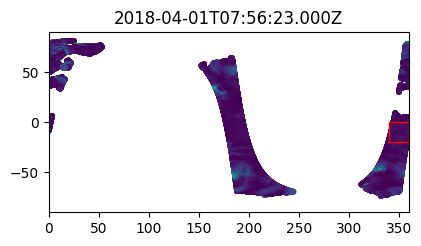

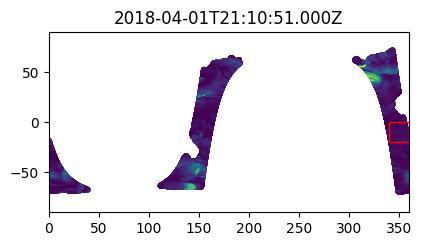

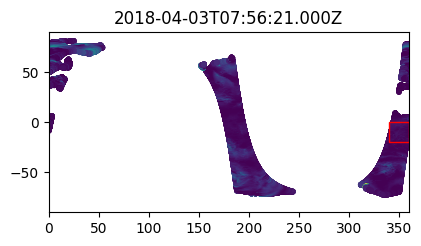

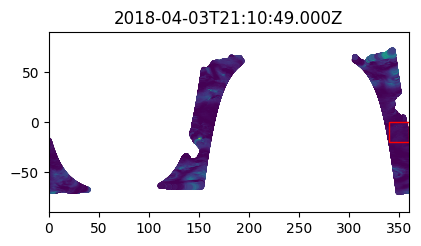

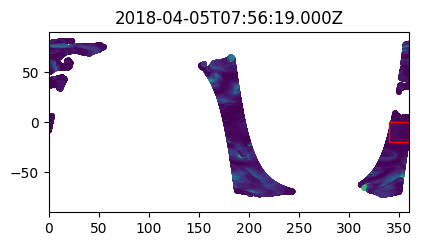

In [55]:
%%time

n_plot = 5
figs = [plt.figure(figsize=(4,2)) for n in range(n_plot)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

bbox_width = bbox_0360[2] - bbox_0360[0]
bbox_height = bbox_0360[3] - bbox_0360[1]

for fo, ax, dts in zip(fileobjs_bbox[:n_plot], axes, datetimes_str[:n_plot]):
    data = xr.open_dataset(fo)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dts)
    ax.scatter(
        data['lon'], data['lat'], c=data['wind_stress_magnitude'], 
        marker='.', zorder=-99, vmin=0, vmax=1.5
    )
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])

## 4.1.2 Test spatial search with VDS

In [58]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [63]:
%%time
data_vds = opends_withref('SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_virtual_s3_concat-time.json', fs)
data_vds

CPU times: user 1.16 s, sys: 170 ms, total: 1.33 s
Wall time: 1.63 s


<xarray.Dataset> Size: 935GB
Dimensions:                        (orbit_start_time: 13145, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 105kB 20...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [67]:
data_vds_bbox = data_vds.sel(orbit_start_time = datetimes_obj)
data_vds_bbox

<xarray.Dataset> Size: 192GB
Dimensions:                        (orbit_start_time: 2701, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 22kB 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

CPU times: user 1.4 s, sys: 63.3 ms, total: 1.47 s
Wall time: 3.45 s


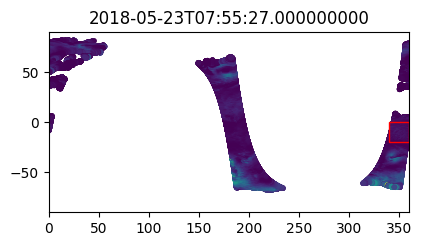

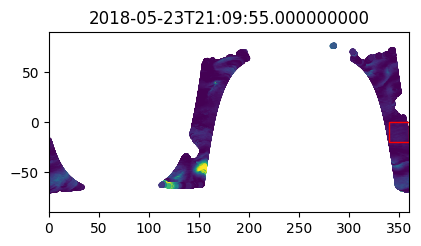

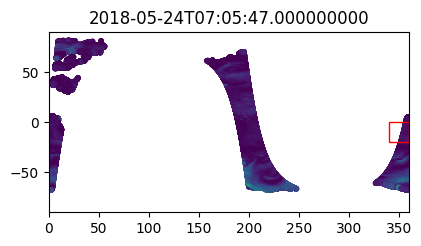

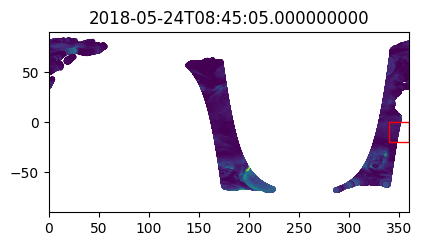

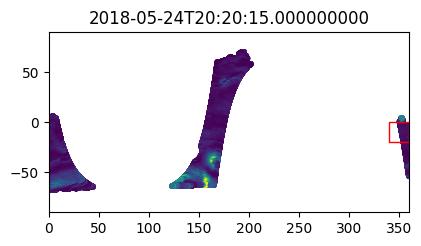

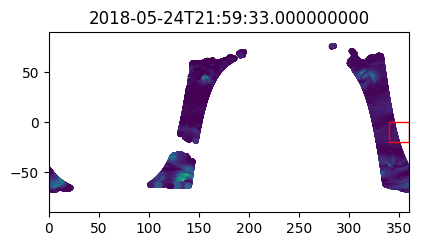

In [70]:
%%time

i_plot_start = 99
i_plot_end = 105
figs = [plt.figure(figsize=(4,2)) for n in range(i_plot_end - i_plot_start)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

bbox_width = bbox_0360[2] - bbox_0360[0]
bbox_height = bbox_0360[3] - bbox_0360[1]

for ax, dt in zip(axes, data_vds_bbox["orbit_start_time"].values[i_plot_start:i_plot_end]):
    data_sub = data_vds_bbox.sel(orbit_start_time = dt)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dt)
    ax.scatter(
        data_sub['lon'], data_sub['lat'], c=data_sub['wind_stress_magnitude'], 
        marker='.', zorder=-99, vmin=0, vmax=1.5
    )
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])

## 4.2 Temporal Subsetting

In [74]:
tstart = "2018-07-01T00:00:00"
tend = "2018-09-01T00:00:00"

In [78]:
data_tsub = data_vds.sel(orbit_start_time = slice(np.datetime64(tstart), np.datetime64(tend)))
data_tsub

<xarray.Dataset> Size: 60GB
Dimensions:                        (orbit_start_time: 850, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 7kB 2018...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

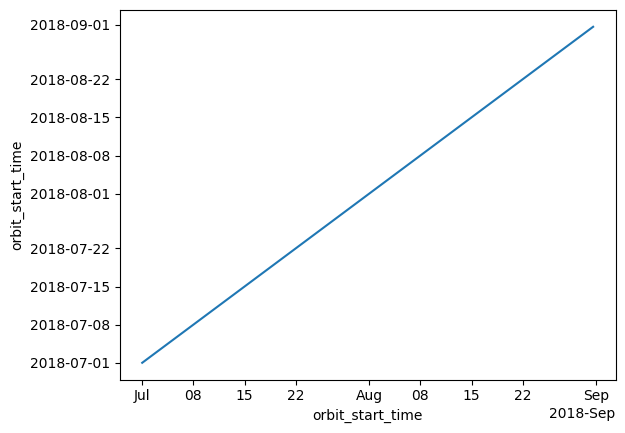

In [79]:
data_tsub["orbit_start_time"].plot()